<i><h1 style="text-align:center;color:#FFFFF">Análisis Jornadas Exploratorias 1° y 2° Medio 2021</h1></i>
<i><h3 style="text-align:center;color:#FFFFF">por : Christian Vergara Retamal</h3></i></i>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
from wordcloud import WordCloud, STOPWORDS # Librería para Nube de palabras
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords 
from textblob import TextBlob
from googletrans import Translator
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
#import Levenshtein
import re
from googletrans import Translator
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pickle

In [3]:
plt.style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (12,8)
plt.rcParams["figure.dpi"] = 60

In [4]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

## Prepracíon De Ambiente de Trabajo

In [5]:
df = pd.read_csv("file.csv")

In [6]:
df.head()

,Marca temporal,Correo,Establecimiento,Selecciona las actividades que te parecieron más interesantes,¿Qué te gustaría haber visto en las Jornadas Exploratorias?,En qué actividades te gustaría participar,Evalúa tu experiencia general en las Jornadas Exploratorias,Cuéntanos que te parecieron las Jornadas Exploratorias.
0,2021/09/09 6:01:13 p. m. GMT-3,valentinaquezada905@gmail.com,Liceo Hualañe,"Motivación, perseverancia y NEM;Proyecto de vi...",todo lo que queria ver lo vi,Talleres Prácticos;Charla con docentes y estud...,7,"me parecieron muy buenas, en lo personal me en..."
1,2021/09/09 6:01:39 p. m. GMT-3,aveloso020@gmail.com,Colegio Andes Talca,Hábitos y Técnicas de estudios;Proyecto de vid...,test vocacionales tal vez,Talleres Prácticos;Charla con docentes y estud...,6,"genial, me resolvieron dudas y me encantaron."
2,2021/09/09 6:01:52 p. m. GMT-3,sofia.orellana.carrasco@gmail.com,chilean eagles college las vizcachas,Proyecto de vida : Herramientas para decidir;D...,los diferentes temas de cada área,"Jornadas de ""Descubrimiento Vocacional""",5,muy entretenidas y fácil de entender
3,2021/09/09 6:01:53 p. m. GMT-3,martinzuniga.estudiante@hualaneduca.cl,Liceo Bicentenario Hualañé,Hábitos y Técnicas de estudios;Descubriendo Ci...,Un acercamiento más a detalle sobre una clase ...,Talleres Prácticos;Charla con docentes y estud...,7,"Bastante entretenidas, además de que aprendí m..."
4,2021/09/09 6:02:15 p. m. GMT-3,damarisneiraacevedo@gmail.com,Liceo Marta Donoso Espejo,"Motivación, perseverancia y NEM;Proyecto de vi...",Tipos de becas para la universidad,Talleres Prácticos;Conocer dependencias virtua...,6,Muy buenas


In [7]:
df.shape

(45, 8)

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(45, 8)

In [10]:
df.columns

Index(['Marca temporal', 'Correo', 'Establecimiento',
       'Selecciona las actividades que te parecieron más interesantes',
       '¿Qué te gustaría haber visto en las Jornadas Exploratorias?',
       'En qué actividades te gustaría participar ',
       'Evalúa tu experiencia general en las Jornadas Exploratorias',
       'Cuéntanos que te parecieron las Jornadas Exploratorias.'],
      dtype='object')

### Modificación de columnas

In [11]:
df.rename(columns={"Marca temporal":"TimeStamp",
                   "Selecciona las actividades que te parecieron más interesantes": "TopActivities",
                  "¿Qué te gustaría haber visto en las Jornadas Exploratorias?": "queFalto",
                  "En qué actividades te gustaría participar ": "actividades_gustos",
                  "Evalúa tu experiencia general en las Jornadas Exploratorias": "calificacion",
                  "Cuéntanos que te parecieron las Jornadas Exploratorias.": "comentarios"}, inplace=True)

## Funciones

In [12]:
def plot_by_column(df, pregunta):
    aux_dict = df[pregunta].value_counts().to_dict()
    y = list(aux_dict.values())
    plt.barh(*zip(*aux_dict.items()))
    for index, value in enumerate(y):
        plt.text(value, index, str(value))
    plt.title('Comportamiento de respuestas de {}'.format(pregunta))
    plt.show()
    plt.tight_layout()

In [13]:
def Binarizer(df, col):
    dummy = pd.get_dummies(df[col].str.get_dummies(sep=';'), drop_first=True)
    df = df.drop(col, axis = 1) 
    df = pd.concat([df, dummy], axis=1)
    return df

In [14]:
def separateAnswers(df, var):
    df_aux = pd.DataFrame()
    df_aux[var] = df[var]
    #df_aux.var=df_aux.var.str.replace(' ', '', regex=False)

    df_aux = Binarizer(df_aux, var)

    lista_cols = list(df_aux.columns)
    lista_counts = []
    count = 0
    for col in df_aux.columns:
        for index, row in df_aux.iterrows():
            if row[col] == 1:
                count +=1
        lista_counts.append(count)
        count = 0

    dicti = dict(zip(lista_cols, lista_counts))

    dicti = {k: v for k, v in sorted(dicti.items(), key=lambda item: item[1])}
    return dicti

In [15]:
def plot_hist_custom(var, titulo = "por defecto"):
    tmp = var.dropna() # Borramos, si es que existen nulls
    plt.hist(tmp, color = 'dodgerblue')
    plt.title(titulo, size = 17)
    plt.axvline(tmp.mean(), color = 'tomato', linewidth = 2,
                linestyle = '--', label = 'Media de la variable')
    plt.legend()

In [52]:
def wordCloud(dataframe, pregunta, palabras):
    df_temp = pd.DataFrame()
    df_temp[pregunta] = dataframe[pregunta]
    comment_words = ''
    stopwords = set(STOPWORDS)
    # Agregamos las palabras en español a las 'stopwords'
    stopwords.update(palabras)
    for val in df_temp[pregunta].values:
        val = str(val)
        tokens = val.split()
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "
    wordcloud = WordCloud(width=800, height=800, stopwords = stopwords, min_font_size= 10).generate(comment_words)
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation="bilinear") 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

In [17]:
# Utilizamos el archivo 'sp_words', el cuál contiene palabras que se
# omitiran al generar el wordcloud. Por ej. 'de', 'un', 'una', 'y', etc.
spanish_words = open('sp_words.txt').read().splitlines()
stopwords_gral = set(STOPWORDS)
# Agregamos las palabras en español a las 'stopwords'
stopwords_gral.update(spanish_words)

## Preguntas

In [18]:
df.columns

Index(['TimeStamp', 'Correo', 'Establecimiento', 'TopActivities', 'queFalto',
       'actividades_gustos', 'calificacion', 'comentarios'],
      dtype='object')

----

### TimeStamp

----

### Correo

----

### Establecimiento

----

### Selecciona las actividades que te parecieron más interesantes

In [19]:
df_top_activities = df.copy()

In [20]:
graf_top_activities = separateAnswers(df_top_activities, "TopActivities")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


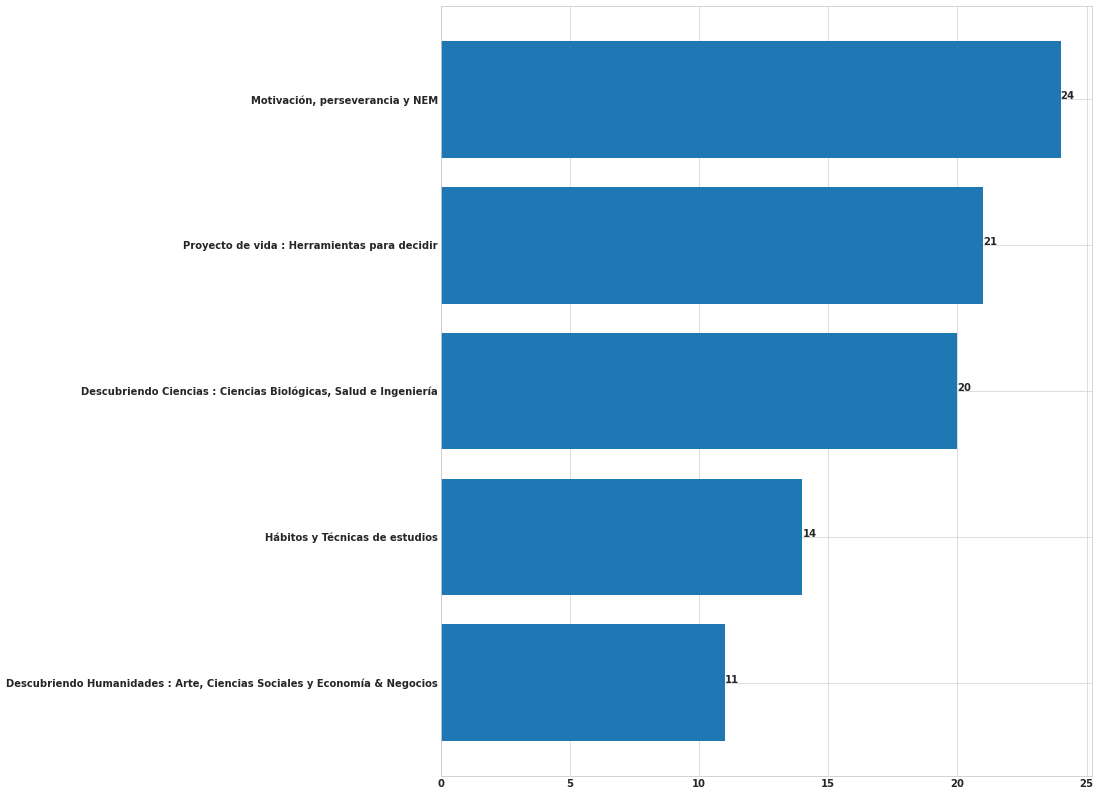

<Figure size 720x480 with 0 Axes>

In [21]:
plt.figure(figsize=(14,17))
plt.barh(*zip(*graf_top_activities.items()))
y = list(graf_top_activities.values())
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.title("")
plt.show()
plt.tight_layout()

----

### Qué te gustaría haber visto en las Jornadas Exploratorias

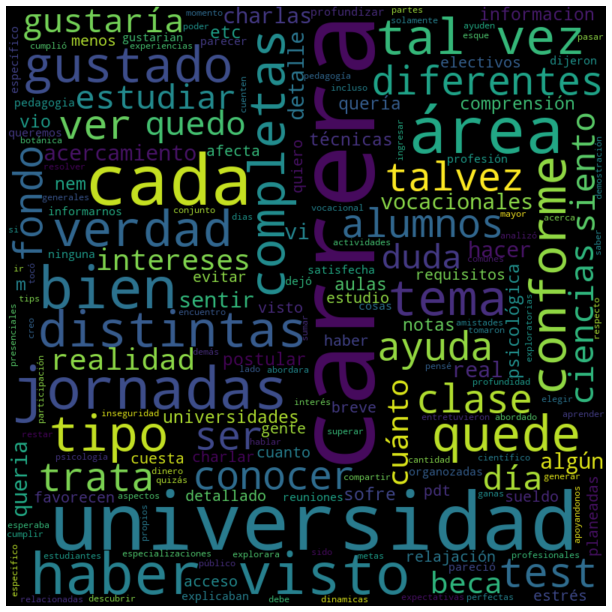

In [53]:
wordCloud(df, 'queFalto', spanish_words)

----

### En qué actividades te gustaría participar

In [23]:
df_actividades_gustos = df.copy()

In [24]:
graf_actividades_gustos = separateAnswers(df_actividades_gustos, "actividades_gustos")

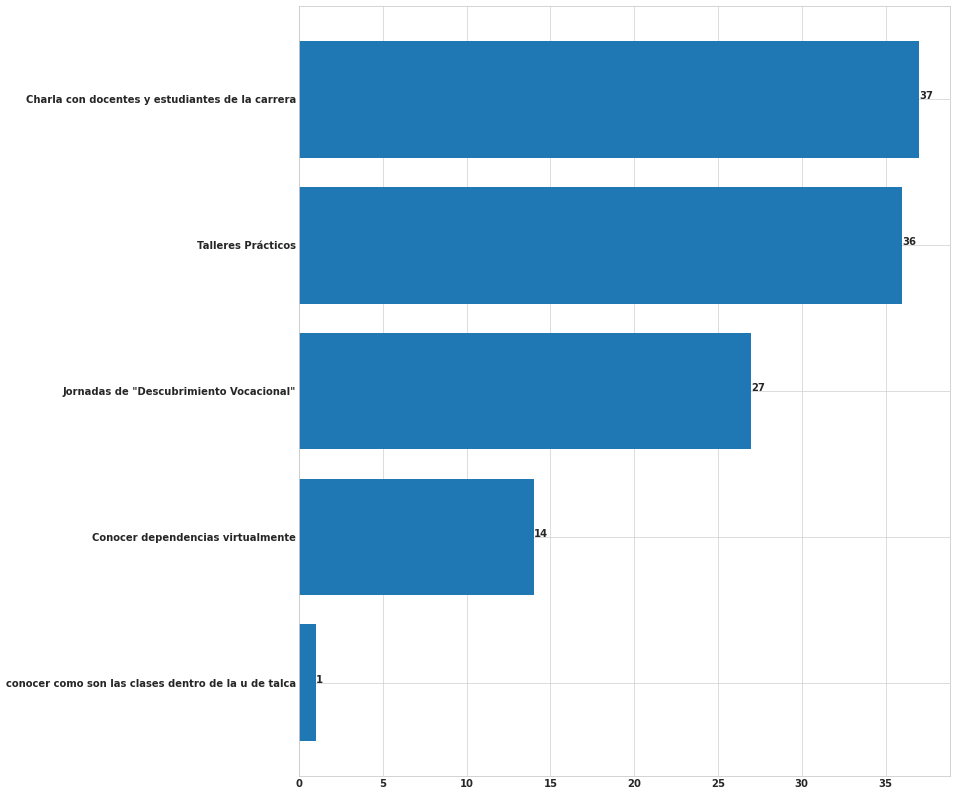

<Figure size 720x480 with 0 Axes>

In [25]:
plt.figure(figsize=(14,17))
plt.barh(*zip(*graf_actividades_gustos.items()))
y = list(graf_actividades_gustos.values())
for index, value in enumerate(y):
    plt.text(value, index, str(value))
plt.title("")
plt.show()
plt.tight_layout()

----

### Evalúa tu experiencia general en las Jornadas Exploratorias

<AxesSubplot:>

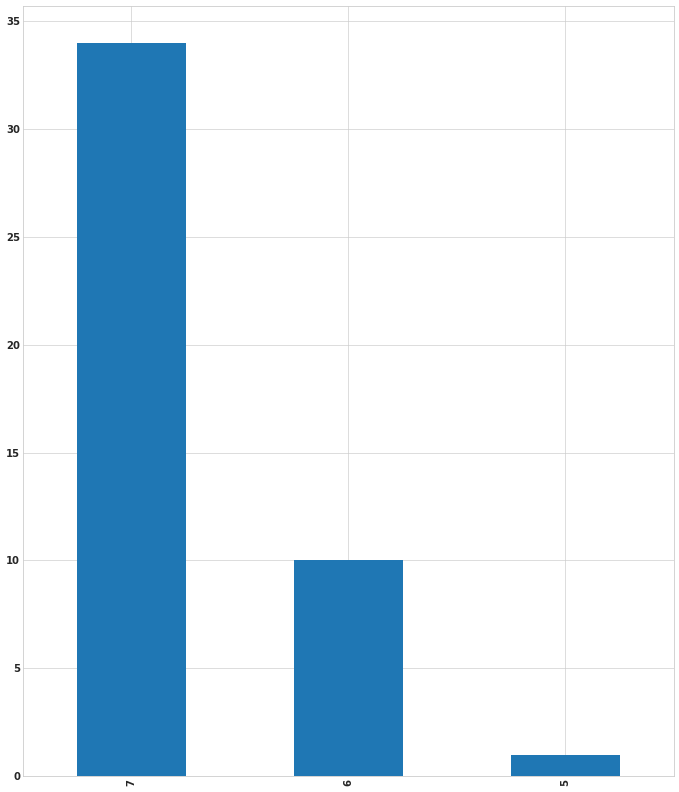

In [26]:
plt.figure(figsize=(14,17))
df['calificacion'].value_counts().plot(kind="bar")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


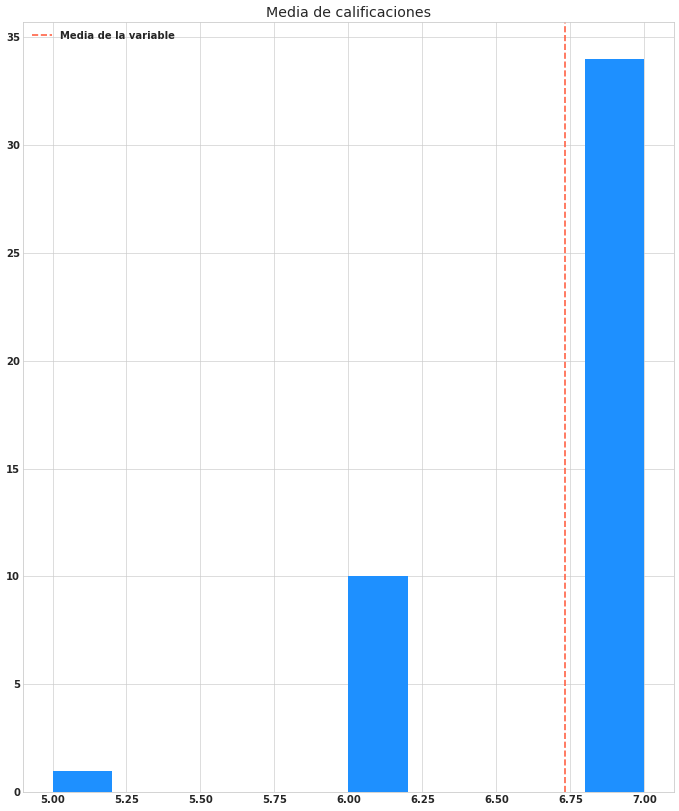

In [27]:
plt.figure(figsize=(14,17))
plot_hist_custom(df['calificacion'], 'Media de calificaciones')

----

### Cuéntanos que te parecieron las Jornadas Exploratorias

#### WordCloud

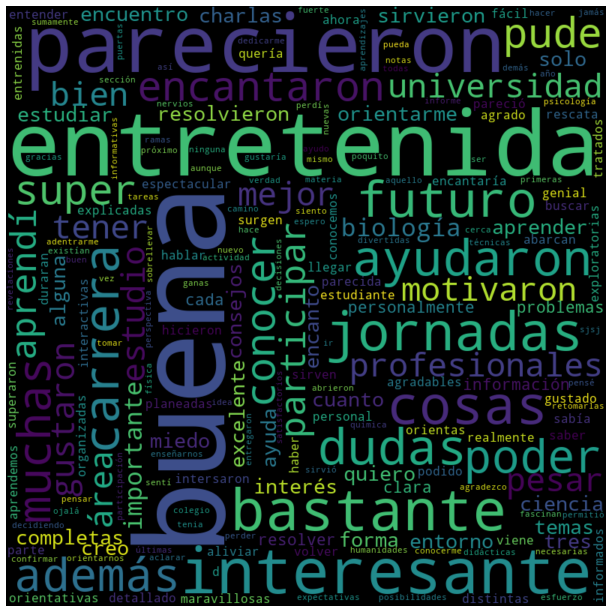

In [51]:
wordCloud(df, 'comentarios', spanish_words)

#### Análisis de Sentimientos

In [29]:
# Creamos dataframe de prueba 
df_comentario = pd.read_csv("comentarios_en.csv")

In [30]:
df_comentario.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

In [31]:
df_comentario.sample(7)

,comentario,comentario_en
40,"Estas jornadas me parecieron muy buenas, es im...","These days seemed very good to me, it is impor..."
19,Maravillosas y muy completas. Pero me hubiera ...,Wonderful and very complete. But I wish they l...
28,"Muy interesantes, me informe de muchas cosas c...","Very interesting, I learned about many things ..."
27,"Me gustaron bastante, me resolvieron bastantes...","I liked them a lot, they solved many doubts I ..."
39,Considero que cada una de las jornadas a las q...,I consider that each of the sessions I attende...
30,"Me gustaron mucho, aprendí muchas cosas, me si...","I liked them a lot, I learned many things, it ..."
25,Superaron mis expectativas y me ayudaron a ori...,They exceeded my expectations and helped me or...


In [32]:
#load the descriptions into textblob
desc_blob = [TextBlob(desc) for desc in df_comentario['comentario_en']]
#add the sentiment metrics to the dataframe
df_comentario['tb_Pol'] = [b.sentiment.polarity for b in desc_blob]
#load VADER
analyzer = SentimentIntensityAnalyzer()
#Add VADER metrics to dataframe
df_comentario['compound'] = [analyzer.polarity_scores(v)['compound'] for v in df_comentario['comentario_en']]
df_comentario['neg'] = [analyzer.polarity_scores(v)['neg'] for v in df_comentario['comentario_en']]
df_comentario['neu'] = [analyzer.polarity_scores(v)['neu'] for v in df_comentario['comentario_en']]
df_comentario['pos'] = [analyzer.polarity_scores(v)['pos'] for v in df_comentario['comentario_en']]

In [33]:
df_comentario

,comentario,comentario_en,tb_Pol,compound,neg,neu,pos
0,"me parecieron muy buenas, en lo personal me en...","I found them very good, personally I loved the...",0.622000,0.9061,0.000,0.601,0.399
1,"genial, me resolvieron dudas y me encantaron.","great, they solved my doubts and I loved them.",0.750000,0.8360,0.127,0.289,0.584
2,muy entretenidas y fácil de entender,very entertaining and easy to understand,0.541667,0.7474,0.000,0.386,0.614
3,"Bastante entretenidas, además de que aprendí m...","Quite entertaining, plus I learned a lot of th...",0.500000,0.4927,0.000,0.715,0.285
4,Muy buenas,Very good,0.910000,0.4927,0.000,0.238,0.762
5,Fueron entretenidas y de alguna forma ayuda el...,They were entertaining and in some way it help...,0.500000,0.6705,0.000,0.718,0.282
6,Interesantes y entretenidas.,Interesting and entertaining.,0.500000,0.6808,0.000,0.152,0.848
7,"Me pareció espectacular, fueron muy agradables...","I found it spectacular, they were very nice an...",0.626667,0.7233,0.000,0.569,0.431
8,Interesantes y buenas,Interesting and good,0.600000,0.6808,0.000,0.152,0.848
9,"Me encantaron, me motivaron mucho más de lo qu...","I loved them, they motivated me much more than...",0.487500,0.9153,0.000,0.644,0.356


Text(0, 0.5, 'Polaridad')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


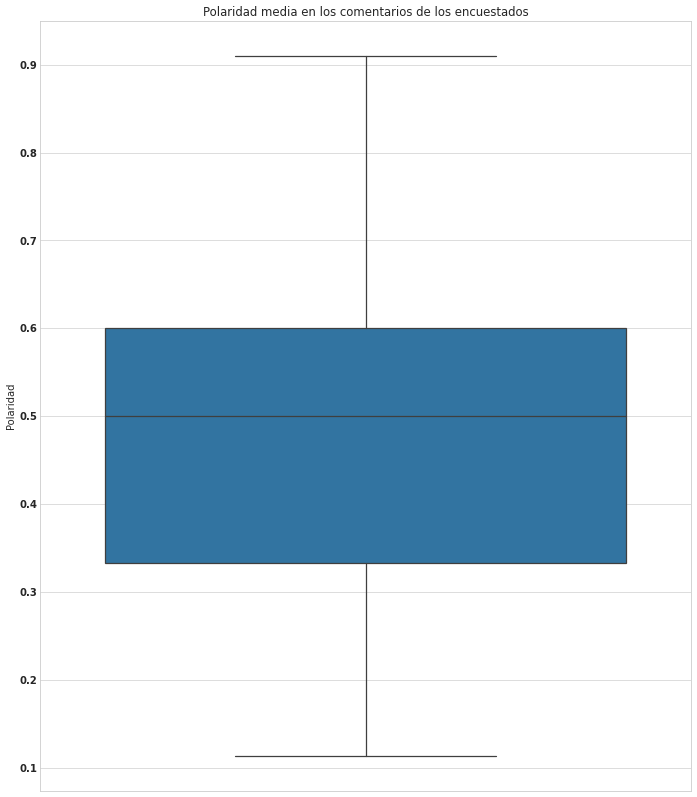

In [34]:
plt.figure(figsize=(14,17))
sns.boxplot(y=df_comentario["tb_Pol"])
plt.xticks([1], [""]);
plt.title("Polaridad media en los comentarios de los encuestados",size = 14)
plt.ylabel("Polaridad")

----

## Análisis comentarios de zoom

In [47]:
zoom = pd.read_excel("comentZoom.xlsx")

In [48]:
zoom.columns

Index(['Comentario'], dtype='object')

In [49]:
zoom["Comentario"]

0                                             graciasss
1        A mi se me hicieron muy cortas estas reuniones
2                                se me pasraron volando
3                            cortitas pero entretenidas
4     siendo sincero de todas las que he estado esta...
5                                                 feliz
6      gracias a ustedes por sus jornadas inspiradoras 
7     Muchas gracias por las jornadas, fueron muy út...
8               Gracias por tooodo, nada mas que decir…
9              gracias por motivarnos espero se repita 
10    gracias por darse el tiempo de enseñarnos a no...
11    muchas gracias por las jornadas, súper entrete...
12    Muchas gracias por hacer estas actividades que...
13                              muchas gracias por todo
14    muchas gracias por toda la ayuda y orientación...
15     muchas gracias por todo, espero volver a vernos 
16    muchas gracias por esto, me cayeron super bien...
17                                            mu